In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

## Loading Data Set

In [4]:
import os
import kagglehub
import shutil

#if the file doesn't exist, we need re-download it

path = kagglehub.dataset_download("sakhawat18/asteroid-dataset") #download file
actual_csv_path = os.path.join(path, 'dataset.csv') #append the dataset file to the path dir

In [8]:
df = pd.read_csv(actual_csv_path)
df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]

/tmp/ipython-input-3304511770.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(actual_csv_path)


##Pre-Processing (Removing Non-Useful Information; refer to [MS3](https://github.com/balexdalex42/CSE151A-Group-Project-Gordon-Yang-Nafi-Mahbub-Alex-Tatoian-/tree/Milestone3))

In [9]:
df_new = df.copy()
cols_to_drop = ['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'diameter',
                'albedo', 'diameter_sigma', 'orbit_id', 'epoch_mjd', 'epoch_cal',
                'equinox', 'tp_cal', 'per_y', 'moid_ld']
sigma_cols = ['sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
              'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per']
df_new.drop(columns=cols_to_drop, inplace=True)
df_new.drop(columns=sigma_cols, inplace=True)

In [10]:
final_df = df_new.dropna()
print(final_df.shape)

(932335, 18)


## Starting Unsupervised Learning

### Dropping Output Feature; Not Used for Unsupervised Learning



In [11]:
X = final_df.drop(columns=['pha'])
y = (final_df['pha'] == 'Y').astype(int)

In [12]:
# Encode the columns using one-hot
X = pd.get_dummies(X, drop_first=True)

In [13]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [14]:
# Try a 2D PCA and visualize it
pca2d = PCA(n_components=2)
X_pca2d = pca2d.fit_transform(X_sc)

In [15]:
X_pca2d.shape

(932335, 2)

In [16]:
import seaborn as sns

In [17]:
pca_vis_df = pd.DataFrame({
    'PCA1' : X_pca2d[:,0],
    'PCA2' : X_pca2d[:,1],
    'pha' : y
})

Text(0.5, 1.0, 'Asteroid Dataset Principle Component Analysis (dims=2)')

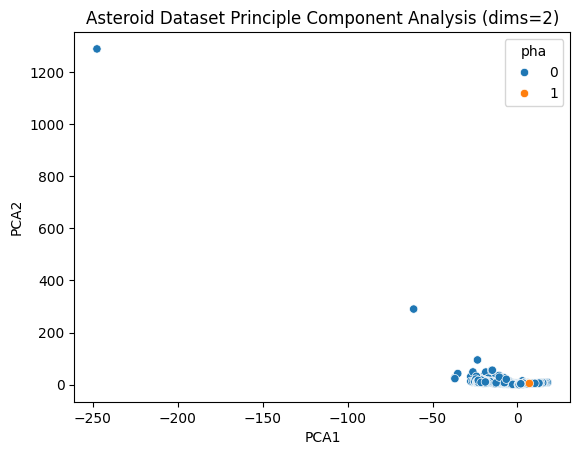

In [18]:
sns.scatterplot(data=pca_vis_df, x='PCA1', y='PCA2', hue='pha')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Asteroid Dataset Principle Component Analysis (dims=2)')

In [19]:
# Let's reduce our data to 5 features
svd5 = TruncatedSVD(n_components=5)
X5 = svd5.fit_transform(X)

In [20]:
svd5.explained_variance_ratio_

array([7.76368763e-06, 9.99992044e-01, 1.86340022e-07, 2.22223697e-09,
       1.96665580e-09])

In [21]:
svd5.singular_values_

array([3.35769092e+09, 2.26055961e+09, 9.75820752e+05, 1.06564400e+05,
       1.00249251e+05])

In [22]:
X5.shape

(932335, 5)

In [23]:
pca5 = PCA(n_components=5)
X_pca5 = pca5.fit_transform(X)

In [24]:
pca5.explained_variance_ratio_

array([9.99999468e-01, 4.65266356e-07, 6.05885756e-08, 2.22223652e-09,
       1.96657447e-09])

In [25]:
pca5.singular_values_

array([2.26056419e+09, 1.54194110e+06, 5.56432298e+05, 1.06564389e+05,
       1.00247178e+05])

In [26]:
pca5.feature_names_in_

array(['h', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp',
       'per', 'moid', 'rms', 'neo_Y', 'class_APO', 'class_AST',
       'class_ATE', 'class_CEN', 'class_IEO', 'class_IMB', 'class_MBA',
       'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO'], dtype=object)

## Model Training (Using KNN)

### Splitting the Data

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (745868, 27)
x_test shape: (186467, 27)
y_train shape: (745868,)
y_test shape: (186467,)


### Getting the SVD of our Training Matrix

In [48]:
#training
scaler = StandardScaler()
X_sc_train = scaler.fit_transform(X_train)
U_train, S_train, V_train_t = np.linalg.svd(X_sc_train, full_matrices=False)
#Need centered testing matrix, note we use training mean though; NO DATA LEAKAGE ALLOWED
X_sc_test = scaler.transform(X_test)


In [49]:
#DEFINING CERTAIN CONSTANTS
max_num_neighbors = 15
#We know that we don't need to iterate to higher dim, since the dimensions would exp 95% of the var
variance_threshold = 0.05

In [53]:
#Now performing the Cross-Validation to get best k-value and number of neighbors
from sklearn.neighbors import KNeighborsClassifier

eigenvals = S_train**2
sum_eigenvalues = np.sum(S_train ** 2)
# explained_variance_ratio = (S_train ** 2) / sum_eigenvalues
# cum_var_ratio = np.cumsum(explained_variance_ratio) #will give us the cum_var_ratio for any k
# print(explained_variance_ratio)
# print(cum_var_ratio)
# k_min = np.argmax(cum_var_ratio >= variance_threshold) + 1 #will give us the min k val that meets threshold
# print(f"k_min: {k_min}")
#iterate over numbers of neighbors
best_macro_f1 = 0
best_k = 0
best_num_neighbors = 0
max_k = 6
for k in range(1, max_k):
  U_k, S_k, Vt_k = U_train[:, :k], S_train[:k], V_train_t[:k, :]
  X_train_k = U_k @ np.diag(S_k) # could've used formula Xc_train @ Vt_k.T
  X_test_k = X_sc_test @ Vt_k.T
  for num_neighbors in range(1, max_num_neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    knn.fit(X_train_k, y_train)
    y_pred = knn.predict(X_test_k)
    report = classification_report(y_test, y_pred, output_dict=True)
    if report['macro avg']['f1-score'] > best_macro_f1:
      best_macro_f1 = report['macro avg']['f1-score']
      best_k = k
      best_num_neighbors = num_neighbors
print(f"best_k: {best_k}")
print(f"best_num_neighbors: {best_num_neighbors}")
print(f"best_macro_f1: {best_macro_f1}")

best_k: 5
best_num_neighbors: 3
best_macro_f1: 0.6779684071645421
